# NetCDF Zarr Sequential Recipe: NOAA OISST

This tutorial describes how to create a recipe from scratch.
The source data is a sequence of NetCDF files accessed via HTTP.
The target is a Zarr store.

## Step 1: Get to know your source data

If you are developing a new recipe, you are probably starting from an existing
dataset. The first step is to just get to know the dataset. For this tutorial,
our example will be the _NOAA Optimum Interpolation Sea Surface Temperature
(OISST) v2.1_. The authoritative website describing the data is
<https://www.ncdc.noaa.gov/oisst/optimum-interpolation-sea-surface-temperature-oisst-v21>.
This website contains links to the actual data files on the
[data access](https://www.ncdc.noaa.gov/oisst/data-access) page. We will use the
_AVHRR-Only_ version of the data and follow the corresponding link to the
[Gridded netCDF Data](https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/).
Browsing through the directories, we can see that there is one file per day. The
very first day of the dataset is stored at the following URL:

```text
https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc
```

From this example, we can work out the pattern of the file naming conventions.
But first, let's just download one of the files and open it up.


In [ ]:
! curl -O https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc 

In [2]:
import xarray as xr

ds = xr.open_dataset("oisst-avhrr-v02r01.19810901.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 1, zlev: 1)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 ...
    err      (time, zlev, lat, lon) float32 ...
    ice      (time, zlev, lat, lon) float32 ...
    sst      (time, zlev, lat, lon) float32 ...
Attributes:
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19810901.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    history:                    Final file created using preliminary as first...
    date_modified:              2020-05-08T19:05:13Z
    date_created:               2020-05-08T19:05:13Z
    product_version:            Version v02r01
    processing_level:           NOAA Level 4
    institution:                NOAA/National Centers for Environmental Infor...
    creator_url:                https://www.ncei.noaa.gov/
    creator_email:              oisst-help@noaa.gov
    keywords:                   Earth Science > Oceans > Ocean Temperature > ...
    keywords_vocabulary:        Global Change Master Directory (GCMD) Earth S...
    platform:                   Ships, buoys, Argo floats, MetOp-A, MetOp-B
    platform_vocabulary:        Global Change Master Directory (GCMD) Platfor...
    instrument:                 Earth Remote Sensing Instruments > Passive Re...
    instrument_vocabulary:      Global Change Master Directory (GCMD) Instrum...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        1981-09-01T00:00:00Z
    time_coverage_end:          1981-09-01T23:59:59Z
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

We can see there are four data variables, all with dimension
`(time, zlev, lat, lon)`. There is a _dimension coordinate_ for each dimension,
and no _non-dimension coordinates_. Each file in the sequence presumably has the
same `zlev`, `lat`, and `lon`, but we expect `time` to be different in each one.

Let's also check the total size of the dataset in the file.


In [3]:
print(f"File size is {ds.nbytes/1e6} MB")

File size is 16.597452 MB


The file size is important because it will help us define the _chunk size_
Pangeo Forge will use to build up the target dataset.


## Step 2: Pick a Recipe class

For our first recipe, we will want to use a pre-defined Recipe class from Pangeo
Forge.

By examining the {doc}`../recipes` documentation page, we see that our scenario is
a good case for the {class}`pangeo_forge.recipe.NetCDFtoZarrSequentialRecipe`
class. Let's examine its documentation string in our notebook.


In [4]:
from pangeo_forge.recipe import NetCDFtoZarrSequentialRecipe
NetCDFtoZarrSequentialRecipe?

Init signature:
NetCDFtoZarrSequentialRecipe(
    input_urls: Iterable[str],
    sequence_dim: str,
    inputs_per_chunk: int = 1,
    nitems_per_input: int = 1,
    target: Union[pangeo_forge.storage.AbstractTarget, NoneType] = <factory>,
    input_cache: Union[pangeo_forge.storage.AbstractTarget, NoneType] = <factory>,
    require_cache: bool = True,
    consolidate_zarr: bool = True,
    xarray_open_kwargs: dict = <factory>,
    xarray_concat_kwargs: dict = <factory>,
    delete_input_encoding: bool = True,
) -> None
Docstring:     
This class represents a dataset composed of many individual NetCDF files.
The files are arraged in a sequence along a single dimension, called the
`sequence_dim`. Each file may contain multiple variables.

The dataset is assembled by concatenating all of these files along `sequence_dim`.
The target is written in Zarr format.

This class uses Xarray to read and write data.

:param input_urls: The inputs used to generate the dataset.
:param sequence_dim: T

## Step 3: Define Recipe parameters

Our chosen class has only two required parameters: `input_urls` and
`sequence_dim`.

`input_urls` is a list of URLs pointing to the data. To populate this, we need
to explicitly create this list based on what we know about the file naming
conventions. Let's look again at the first URL

```text
https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc
```

From this we deduce the following format string.


In [5]:
input_url_pattern = (
    "https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation"
    "/v2.1/access/avhrr/{yyyymm}/oisst-avhrr-v02r01.{yyyymmdd}.nc"
)

Now we need a sequence of datetimes. Pandas is the easiest way to get this. At
the time of writing, the latest available data is from 2021-01-05.


In [6]:
import pandas as pd

dates = pd.date_range("1981-09-01", "2021-01-05", freq="D")
input_urls = [
    input_url_pattern.format(
        yyyymm=day.strftime("%Y%m"), yyyymmdd=day.strftime("%Y%m%d")
    )
    for day in dates
]
print(f"Found {len(input_urls)} files!")
input_urls[-1]

Found 14372 files!


'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202101/oisst-avhrr-v02r01.20210105.nc'

That's a lot of files!

The other remaining parameter is `sequence_dim`. It's just `"time"`.  This is enough to initialize the recipe.

In [7]:
recipe = NetCDFtoZarrSequentialRecipe(
    input_urls=input_urls,
    sequence_dim="time"
)
recipe

NetCDFtoZarrSequentialRecipe(sequence_dim='time', inputs_per_chunk=1, nitems_per_input=1, target=<pangeo_forge.storage.UninitializedTarget object at 0x7ff8b0797f10>, input_cache=<pangeo_forge.storage.UninitializedTarget object at 0x7ff870359820>, require_cache=True, consolidate_zarr=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True)

Now let's think about the Zarr chunks that this recipe will produce.
Each target chunk corresponds to one input. So each variable chunk will only be a few MB.
That is too small. Let's increase `inputs_per_chunk` to 20.
This means that we will need to be able to hold 20 files like the one we examined above in memory at once.
That's `16MB * 20 = 320MB`. Not a problem!

In [8]:
recipe = NetCDFtoZarrSequentialRecipe(
    input_urls=input_urls,
    sequence_dim="time",
    inputs_per_chunk=20
)
recipe

NetCDFtoZarrSequentialRecipe(sequence_dim='time', inputs_per_chunk=20, nitems_per_input=1, target=<pangeo_forge.storage.UninitializedTarget object at 0x7ff8904061c0>, input_cache=<pangeo_forge.storage.UninitializedTarget object at 0x7ff8904061f0>, require_cache=True, consolidate_zarr=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True)

## Step 4: Play with the recipe

Now we will just explore our recipe a bit to check whether things make sense.

We can see how many inputs the recipe has like this:

In [9]:
all_inputs = list(recipe.iter_inputs())
len(all_inputs)

14372

And how many chunks:

In [10]:
all_chunks = list(recipe.iter_chunks())
len(all_chunks)

719

And we can see their dependencies as follows:

In [11]:
print(f'first chunk ID: {all_chunks[0]}')
recipe.inputs_for_chunk(all_chunks[0])

first chunk ID: 0


('https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810903.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810904.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810905.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810906.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810907.nc',
 'https://www.ncei.noaa.gov/data/sea-surf

In [12]:
print(f'last chunk ID: {all_chunks[-1]}')
recipe.inputs_for_chunk(all_chunks[-1])

last chunk ID: 718


('https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202012/oisst-avhrr-v02r01.20201225.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202012/oisst-avhrr-v02r01.20201226.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202012/oisst-avhrr-v02r01.20201227.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202012/oisst-avhrr-v02r01.20201228.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202012/oisst-avhrr-v02r01.20201229.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202012/oisst-avhrr-v02r01.20201230.nc',
 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202012/oisst-avhrr-v02r01.20201231.nc',
 'https://www.ncei.noaa.gov/data/sea-surf

Those are all the files that will go into the first and last chunk. 

We can now try to load the first chunk. This will raise an exception because we have not initialized any targets.

In [13]:
try:
    recipe.open_chunk(all_chunks[0])
except Exception as e:
    print(type(e))

<class 'pangeo_forge.storage.UninitializedTargetError'>


## Step 5: Create storage targets

In order to run our recipe, we need to define two places to store data:
- The Input Cache, where we will temporarily store the files we have downloaded
- The Target, where the final Zarr dataset will live


In [14]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

recipe.input_cache = cache_target
recipe.target = target
recipe

NetCDFtoZarrSequentialRecipe(sequence_dim='time', inputs_per_chunk=20, nitems_per_input=1, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7ff8b0842520>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmppoaidedy'), input_cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7ff8b0842520>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmp61q8ifva'), require_cache=True, consolidate_zarr=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True)

Now we try to load the chunk.

In [15]:
try:
    recipe.open_chunk(all_chunks[0])
except Exception as e:
    print(e)

You are trying to open input https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc, but the file is not cached yet. First call `cache_input` or set `require_cache=False`.


It still didn't work! That's because we have not cached the inputs yet.

In [16]:
for input_file in recipe.inputs_for_chunk(all_chunks[0]):
    recipe.cache_input(input_file)

## Step 6: Examine some chunks

Now we can finally open the first chunk!

In [17]:
ds_chunk = recipe.open_chunk(all_chunks[0])
ds_chunk

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 20, zlev: 1)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 1981-09-20T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 nan nan nan nan ... 0.41 0.41 0.41
    err      (time, zlev, lat, lon) float32 nan nan nan nan ... 0.3 0.3 0.3 0.3
    ice      (time, zlev, lat, lon) float32 nan nan nan nan ... 0.9 0.9 0.9 0.9
    sst      (time, zlev, lat, lon) float32 nan nan nan ... -1.39 -1.39 -1.39
Attributes:
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19810901.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    history:                    Final file created using preliminary as first...
    date_modified:              2020-05-08T19:05:13Z
    date_created:               2020-05-08T19:05:13Z
    product_version:            Version v02r01
    processing_level:           NOAA Level 4
    institution:                NOAA/National Centers for Environmental Infor...
    creator_url:                https://www.ncei.noaa.gov/
    creator_email:              oisst-help@noaa.gov
    keywords:                   Earth Science > Oceans > Ocean Temperature > ...
    keywords_vocabulary:        Global Change Master Directory (GCMD) Earth S...
    platform:                   Ships, buoys, Argo floats, MetOp-A, MetOp-B
    platform_vocabulary:        Global Change Master Directory (GCMD) Platfor...
    instrument:                 Earth Remote Sensing Instruments > Passive Re...
    instrument_vocabulary:      Global Change Master Directory (GCMD) Instrum...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        1981-09-01T00:00:00Z
    time_coverage_end:          1981-09-01T23:59:59Z
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

In [18]:
print(f'Total chunk size: {ds_chunk.nbytes / 1e6} MB')

Total chunk size: 331.784804 MB


👀 Inspect the Xarray HTML repr carefully by clicking on the buttons to expand the different sections.
- ✅ Is the shape of the variable what we expect?
- ✅ Is `time` going in the right order?
- ✅ Do the variable attributes make sense?


Now let's visualize some data and make sure things look good

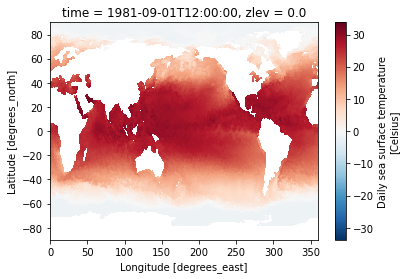

In [19]:
ds_chunk.sst[0].plot()

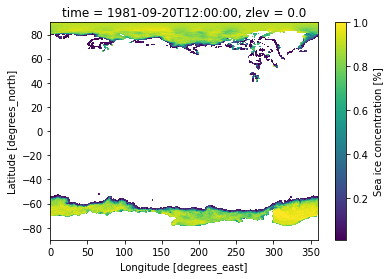

In [20]:
ds_chunk.ice[-1].plot()

The data look good!
Now let's try a random chunk from the middle.

In [21]:
chunk_number = 500
for input_file in recipe.inputs_for_chunk(chunk_number):
    recipe.cache_input(input_file)

In [22]:
ds_chunk = recipe.open_chunk(chunk_number)
ds_chunk

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 20, zlev: 1)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 2009-01-17T12:00:00 ... 2009-02-05T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 nan nan nan nan ... 0.08 0.08 0.08
    err      (time, zlev, lat, lon) float32 nan nan nan nan ... 0.3 0.3 0.3 0.3
    ice      (time, zlev, lat, lon) float32 nan nan nan nan ... 1.0 1.0 1.0 1.0
    sst      (time, zlev, lat, lon) float32 nan nan nan ... -1.72 -1.72 -1.72
Attributes:
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    Description:                Reynolds, et al.(2007) Daily High-resolution ...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20090117.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    history:                    Final file created using preliminary as first...
    date_modified:              2020-05-08T19:05:13Z
    date_created:               2020-05-08T19:05:13Z
    product_version:            Version v02r01
    processing_level:           NOAA Level 4
    institution:                NOAA/National Centers for Environmental Infor...
    creator_url:                https://www.ncei.noaa.gov/
    creator_email:              oisst-help@noaa.gov
    keywords:                   Earth Science > Oceans > Ocean Temperature > ...
    keywords_vocabulary:        Global Change Master Directory (GCMD) Earth S...
    platform:                   Ships, buoys, Argo floats, MetOp-A, MetOp-B
    platform_vocabulary:        Global Change Master Directory (GCMD) Platfor...
    instrument:                 Earth Remote Sensing Instruments > Passive Re...
    instrument_vocabulary:      Global Change Master Directory (GCMD) Instrum...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    geospatial_lat_min:         -90.0
    geospatial_lat_max:         90.0
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        2009-01-17T00:00:00Z
    time_coverage_end:          2009-01-17T23:59:59Z
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

## Step 7: Try writing data

Now that we can see our chunks opening correctly, we are ready to try writing data to our target.

First we need to prepare the target.

In [23]:
recipe.prepare_target()

We should now see a Zarr group at the target location.
Only the coordinates have been written, not the data variables.

In [24]:
import zarr
zgroup = zarr.open(target_dir.name)
print(zgroup.tree())

/
 ├── anom (14372, 1, 720, 1440) float32
 ├── err (14372, 1, 720, 1440) float32
 ├── ice (14372, 1, 720, 1440) float32
 ├── lat (720,) float32
 ├── lon (1440,) float32
 ├── sst (14372, 1, 720, 1440) float32
 ├── time (14372,) int64
 └── zlev (1,) float32


Let's examine one of the data variables.

In [25]:
zgroup['sst'].info

Name,/sst
Type,zarr.core.Array
Data type,float32
Shape,"(14372, 1, 720, 1440)"
Chunk shape,"(20, 1, 720, 1440)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,59603558400 (55.5G)
No. bytes stored,611


Now let's write the first chunk.

In [26]:
recipe.store_chunk(all_chunks[0])
zgroup['sst'].info

Name,/sst
Type,zarr.core.Array
Data type,float32
Shape,"(14372, 1, 720, 1440)"
Chunk shape,"(20, 1, 720, 1440)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,59603558400 (55.5G)
No. bytes stored,39402334 (37.6M)


We can see that one of the chunks has been written! 🎉

We can also open the dataset with xarray

In [27]:
ds = xr.open_zarr(target_dir.name)
ds

,Array,Chunk
Bytes,59.60 GB,82.94 MB
Shape,"(14372, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,720 Tasks,719 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,59.60 GB,82.94 MB
Shape,"(14372, 1, 720, 1440)","(20, 1, 720, 1440)"
Count,720 Tasks,719 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


There should be data at the beginning...

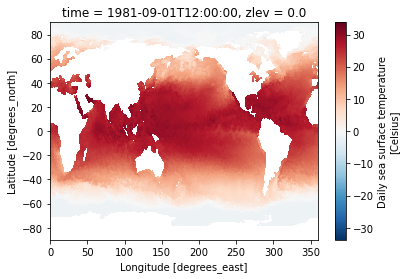

In [28]:
ds.sst[0].plot()

But not the end...

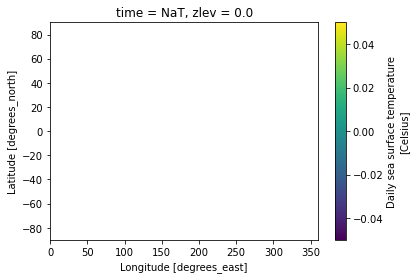

In [29]:
ds.sst[-1].plot()

## Postscript: Execute the full recipe

We are now confident that our recipe works as we expect.
At this point we could either:
- Execute it all ourselves (see {doc}`../execution`)
- Create a new recipe feedstock on Pangeo Forge

If we wanted to execute it ourselves, one way would be to simply run the following code
```python
for input_name in recipe.iter_inputs():
    recipe.cache_input(input_name)
recipe.prepare_target()
for chunk in recipe.iter_chunks():
    recipe.store_chunk(chunk)
recipe.finalize_target()
```

We aren't going to do this in this notebook because it would take too long.

But hopefully now you have a better understanding of how Pangeo Forge recipes work.